In [ ]:
# to do
# do all the modeling

In [93]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from operator import itemgetter


from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.tree import _tree


from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

In [16]:
sns.set()

In [17]:
#df = pd.read_csv('imputed.csv')

## Impute + 1 hot encode

In [18]:
initial_df = pd.read_csv('HMEQ_Loss.csv')

In [19]:
#break into groups for initial run
numerical_columns = []
categorical_columns = []
other_cols = []

dt=initial_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (["object"]) : 
        categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        numerical_columns.append(i)
    else:
        other_cols.append(i)


In [20]:
#impute the categorical columns
#drop the originals
imputed_df = initial_df.copy()
for i in categorical_columns :
    if imputed_df[i].isna().sum() == 0: 
        continue
    NAME = "IMP_"+i
    imputed_df[NAME] = imputed_df[i]
    imputed_df[NAME] = imputed_df[NAME].fillna(imputed_df[NAME].mode()[0])
    print("variable",i," has this many missing", imputed_df[i].isna().sum())
    print("variable",NAME," has this many missing", imputed_df[NAME].isna().sum() ,'\n')
    g = imputed_df.groupby(NAME)
    print(g[NAME].count())
    print("\n\n")
    imputed_df = imputed_df.drop(i, axis=1)

variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0 

IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0 

IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64





In [21]:
#impute the numerical columns
#drop the originals
missing_flag_cols = []

for i in numerical_columns:
    if imputed_df[i].isna().sum() == 0:
        continue
    FLAG = 'M_' + i
    IMP = 'IMP_' + i
    imputed_df[FLAG] = imputed_df[i].isna() + 0
    missing_flag_cols.append(FLAG)
    imputed_df[IMP] = imputed_df[i]
    imputed_df.loc[imputed_df[IMP].isna(),IMP] = imputed_df[i].median()
    imputed_df = imputed_df.drop(i, axis=1)

In [22]:
#break into groups again with the dropped cols
imp_numerical_columns = []
imp_categorical_columns = []
imp_other_cols = []

dt=imputed_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (missing_flag_cols):
        imp_other_cols.append(i)
    elif dt[i] in (["object"]) : 
        imp_categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        imp_numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        imp_numerical_columns.append(i)
    else:
        imp_other_cols.append(i)

In [23]:
#now one hot encode the categorical columns
for i in imp_categorical_columns:
    prefix_name = 'z_' + i
    y = pd.get_dummies(imputed_df[i],prefix=prefix_name,drop_first=True)
    imputed_df = pd.concat([imputed_df,y],axis=1)
    imputed_df = imputed_df.drop(i,axis=1)


## Remove the outliers from the dataset


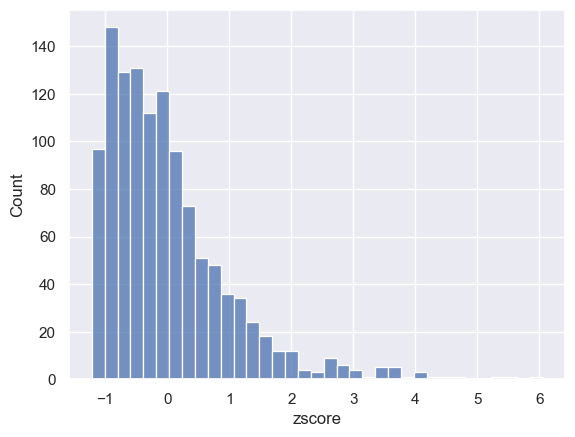

In [24]:
# from the imputed DF, let's keep only things within 3 standard deviations
# we'll use the scipy stats package to get the zscore
outlier_vis = imputed_df.copy()
outlier_vis['zscore'] = stats.zscore(outlier_vis[TARGET_A],nan_policy='omit')

# histogram of zscore
plot1 = sns.histplot(x=outlier_vis['zscore'], data=outlier_vis)
fig = plot1.get_figure()
fig.savefig('zscore_hist.png', bbox_inches='tight')
# get the absolute value of the zscore so we don't have to do > & < to get both upper and lower
# then save that as another df to use later on
# super important here is the or statement in filtering the df
# if you don't use the or part, you end up dropping all the nondefaults
imputed_no_outlier = imputed_df[(np.abs(stats.zscore(imputed_df[TARGET_A],nan_policy='omit')) < 3)\
                                 | ~imputed_df[TARGET_F].isna()].copy()

## Split the Data Into Test & Train

In [25]:
# drop the targets
# keep the predictors
# drop the missing flags as well
# uncomment to use no outlier
X = imputed_no_outlier.copy()
#X = imputed_df.copy()
X = X.drop(TARGET_F,axis=1)
X = X.drop(TARGET_A,axis=1)

for column in imputed_no_outlier.columns.values:
    if "M_" in column:
        X.drop(column,axis=1,inplace=True)

# the target we're predicting
Y = imputed_no_outlier[[TARGET_F,TARGET_A]]

# keep 80% for training
# keep 20% for testing
# use random_state=1 if you need the results to be the same (this sets our seed)
# X_train and Y_train should match up on the index
# X_test and Y_test should match up on the index
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, \
                                                    train_size=0.8, \
                                                    test_size=.2) #random_state=1

print("Training = ", X_train.shape)
print("Testing = ", X_test.shape)

Training =  (4768, 16)
Testing =  (1192, 16)


## Important Stuff

### Functions

In [46]:
# get tree related important variables

def getTreeVars(TREE, varNames) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add(i)
    nameList = list(nameSet)
    parameter_list = list()
    for i in nameList :
        parameter_list.append(varNames[i])
    return parameter_list

def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_) :
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [84]:
# get Regression model important variables
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    return coef_dict

def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    return coef_dict

### Classes

In [64]:
class AmountModel:
    # on creation
    def __init__(self, name, x_train, x_test, y_train, y_test,depth=5,random_state=511,estimators=100):
        self.name = name
        self.depth = depth
        self.r_state = random_state
        self.n_estimators = estimators
        self.features = list(x_train.columns.values)
        # get no null index
        amount_train_index = ~y_train[TARGET_A].isna()
        amount_test_index = ~y_test[TARGET_A].isna()

        # init amount variables
        self.X_Train = x_train[amount_train_index]
        self.Y_Train = y_train[amount_train_index]
        self.Y_Train = self.Y_Train[TARGET_A]
        self.X_Test = x_test[amount_test_index]
        self.Y_Test = y_test[amount_test_index]
        self.Y_Test = self.Y_Test[TARGET_A]
        print("After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy()")

    def setFlavor(self,flavor):
        if flavor == 'Tree':
            self.model = tree.DecisionTreeRegressor(max_depth=self.depth,random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Random Forest':
            self.model = RandomForestRegressor(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Gradient Boost':
            self.model = GradientBoostingRegressor(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        else:
            print('ERROR, please input Tree, Random Forest, Gradient Boost, or  Regression')

    def fit(self):
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)

    def getVars(self):
        if self.flavor == 'Tree':
            self.important_variables = getTreeVars(self.model,self.features)
            return self.important_variables
        elif self.flavor == 'Gradient Boost' or self.flavor == 'Random Forest':
            holder = getEnsembleTreeVars(self.model,self.features)
            self.important_variables = []
            for i in holder:
                smallhold = i[0]
                self.important_variables.append(smallhold)
            self.import_variables_matrix = holder
            return self.important_variables
        else: 
            print('error')
            
    def getAccuracy(self):
        self.RMSE_train = math.sqrt(metrics.mean_squared_error(self.Y_Train,self.Y_Pred_Train))
        self.RMSE_test = math.sqrt(metrics.mean_squared_error(self.Y_Test,self.Y_Pred_Test))
        print(f"{self.name} RMSE Train: ", self.RMSE_train)
        print(f"{self.name} RMSE Test: ", self.RMSE_test)

In [63]:
class FlagModel:
    # on creation
    def __init__(self, name, x_train, x_test, y_train, y_test,depth=5,random_state=511,estimators=100):
        self.name = name
        self.depth = depth
        self.r_state = random_state
        self.n_estimators = estimators
        self.features = list(x_train.columns.values)
        
        # init flag variables
        self.X_Train = x_train
        self.Y_Train = y_train[TARGET_F]
        self.X_Test = x_test
        self.Y_Test = y_test[TARGET_F]
        print("After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy() and a .makeROCplot()")

    def setFlavor(self,flavor):
        if flavor == 'Tree':
            self.model = tree.DecisionTreeClassifier(max_depth=self.depth,random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Random Forest':
            self.model = RandomForestClassifier(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        elif flavor == 'Gradient Boost':
            self.model = GradientBoostingClassifier(n_estimators = self.n_estimators, max_depth=self.depth,\
                                                random_state=self.r_state)
            self.flavor = flavor
        else:
            print('ERROR, please input Tree, Random Forest, or Gradient Boost')


    def fit(self):
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)

    def getVars(self):
        if self.flavor == 'Tree':
            self.important_variables = getTreeVars(self.model,self.features)
            return self.important_variables
        elif self.flavor == 'Gradient Boost' or self.flavor == 'Random Forest':
            holder = getEnsembleTreeVars(self.model,self.features)
            self.important_variables = []
            for i in holder:
                smallhold = i[0]
                self.important_variables.append(smallhold)
            self.import_variables_matrix = holder
            return self.important_variables
        else: 
            print('error')
    

    def getAccuracy(self):
        self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
        self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
        print("Accuracy Train: ", self.train_acc)
        print("Accuracy Test: ", self.test_acc)

    def makeROCplot(self,filename):
        self.train_probs = self.model.predict_proba(self.X_Train)
        self.test_probs = self.model.predict_proba(self.X_Test)
        self.train_probs = self.train_probs[:,1]
        self.test_probs = self.test_probs[:,1]
        self.fpr_train, self.tpr_train, self.train_threshold = metrics.roc_curve(self.Y_Train, self.train_probs)
        self.fpr_test, self.tpr_test, self.test_threshold = metrics.roc_curve(self.Y_Test, self.test_probs)
        self.roc_auc_train = metrics.auc(self.fpr_train, self.tpr_train)
        self.roc_auc_test = metrics.auc(self.fpr_test, self.tpr_test)
        self.roc_plot = plt.figure(figsize=(10,10))
        plt.title(self.name + " ROC Curve")
        plt.plot(self.fpr_train, self.tpr_train,'b',label = 'AUC Train = %0.2f' % self.roc_auc_train)
        plt.plot(self.fpr_test, self.tpr_test,'r',label = 'AUC Test = %0.2f' % self.roc_auc_test)
        plt.legend(loc = 'lower right')
        plt.plot([0,1],[0,1],'k--')
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.savefig(filename+'.png', bbox_inches='tight')
        plt.show()

    

        


    

In [91]:
class StepWiseModel():
   def __init__(self, name, x_train, x_test, y_train, y_test,flavor,
                solver='newton-cg',maxiter=100,kmax=1,forward=True,floating=False,scoring='r2',cv=3):
      self.name = name
      self.solver = solver
      self.maxiterations = maxiter
      self.features = list(x_train.columns.values)
      self.flavor = flavor
      self.kmax = kmax
      self.forward=forward
      self.floating=floating
      self.scoring=scoring
      self.cv=cv

      if flavor == "Logistic":
         self.X_Train = x_train
         self.Y_Train = y_train[TARGET_F]
         self.X_Test = x_test
         self.Y_Test = y_test[TARGET_F]
      else:
         # get no null index
         amount_train_index = ~y_train[TARGET_A].isna()
         amount_test_index = ~y_test[TARGET_A].isna()

         # init amount variables
         self.X_Train = x_train[amount_train_index]
         self.Y_Train = y_train[amount_train_index]
         self.Y_Train = self.Y_Train[TARGET_A]
         self.X_Test = x_test[amount_test_index]
         self.Y_Test = y_test[amount_test_index]
         self.Y_Test = self.Y_Test[TARGET_A]

   def fit(self):
      if self.flavor == "Logistic":
         self.model = SFS(LogisticRegression(solver=self.solver,max_iter=self.maxiterations),
                          k_features = (1,self.kmax),
                          forward=self.forward,
                          floating=self.floating,
                          cv=self.cv)
         self.model.fit(self.X_Train.values,self.Y_Train.values)

      elif self.flavor == "Linear":
         self.model = SFS(LinearRegression(),
                          k_features = (1,self.kmax),
                          forward=self.forward,
                          floating=self.floating,
                          scoring=self.scoring,
                          cv=self.cv)
         self.model.fit(self.X_Train.values,self.Y_Train.values)

      else:
         print('error')

   def plot(self,filename):
      self.fig = plot_sfs(self.model.get_metric_dict(), kind = None)
      plt.title(self.name + ' Sequential Forward Selection (w. StdErr)')
      plt.grid()
      plt.savefig(filename+'.png', bbox_inches='tight')
      plt.show()
   

   def getMax(self):
      dfm = pd.DataFrame.from_dict(self.model.get_metric_dict()).T
      dfm = dfm[['feature_names', 'avg_score']]
      dfm['avg_score'] = dfm['avg_score'].astype(float)
      maxIndex = dfm['avg_score'].argmax()
      stepVars = dfm.iloc[maxIndex,]
      stepVars = stepVars['feature_names']
      self.import_variables_matrix = stepVars
      holder = []
      for i in stepVars :
         index = int(i)
         try :
            theName = self.features[index]
            holder.append(theName)
         except :
            pass
      self.important_variables = holder

In [81]:
class LogModel(FlagModel):
    def __init__(self,name, x_train, x_test, y_train, y_test, solver='newton-cg',maxiter=1000):
        super().__init__(name, x_train, x_test, y_train, y_test,depth=5,random_state=511,estimators=100)
        self.solver = solver
        self.maxiterations = maxiter
        self.flavor = 'Logistic'
    
    def fit(self):
        self.model = LogisticRegression(solver = self.solver, max_iter = self.maxiterations)
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)
    
    def getVars(self):
        self.important_variables = getCoefLogit(self.model,self.X_Train)
        return self.important_variables
    
class LinModel(AmountModel):
    def __init__(self,name, x_train, x_test, y_train, y_test, estimators=100,solver='newton-cg',maxiter=1000):
        super().__init__(name, x_train, x_test, y_train, y_test,depth=5,random_state=511)
        self.n_estimators = estimators
        self.solver = solver
        self.maxiterations = maxiter
        self.flavor = 'Logistic'
    
    def fit(self):
        self.model = LinearRegression()
        self.model = self.model.fit(self.X_Train,self.Y_Train)
        self.Y_Pred_Train = self.model.predict(self.X_Train)
        self.Y_Pred_Test = self.model.predict(self.X_Test)
    
    def getVars(self):
        self.important_variables = getCoefLinear(self.model,self.X_Train)
        return self.important_variables

After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy() and a .makeROCplot()
Accuracy Train:  0.9653942953020134
Accuracy Test:  0.9035234899328859


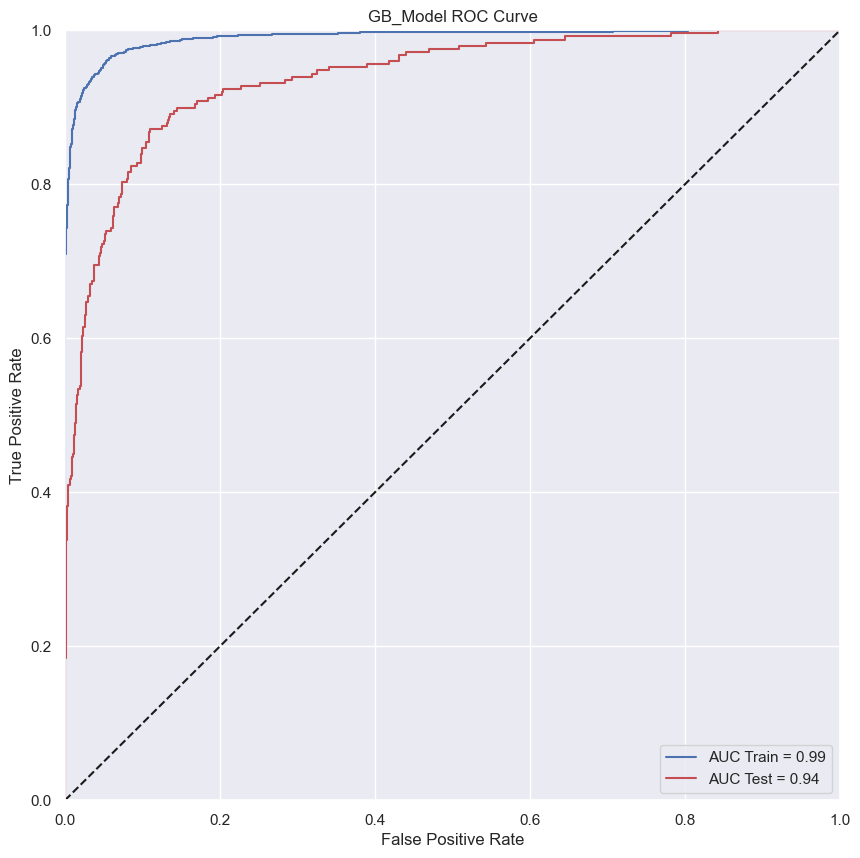

['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_CLAGE', 'IMP_VALUE']

In [65]:
treeflag = FlagModel('GB_Model',X_train, X_test, Y_train, Y_test)
treeflag.setFlavor('Gradient Boost')
treeflag.fit()
treeflag.getAccuracy()
treeflag.makeROCplot('pickle')
treeflag.getVars()

In [ ]:
treeflag = FlagModel('GB_Model',X_train, X_test, Y_train, Y_test)
treeflag.setFlavor('Gradient Boost')
treeflag.fit()
treeflag.getAccuracy()
treeflag.makeROCplot('pickle')
treeflag.getVars()

In [73]:
type(treeflag.important_variables)

list

In [86]:
GB_Lin = LinModel('GB_Log',X_train[treeflag.important_variables], X_test[treeflag.important_variables], Y_train, Y_test)
GB_Lin.fit()
GB_Lin.getAccuracy()
#GB_Lin.makeROCplot('pickle')
GB_Lin.getVars()

After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy()
GB_Log RMSE Train:  9388.158008276127
GB_Log RMSE Test:  10968.366862224218


{'INTERCEPT': 2340.8961241606485,
 'IMP_DEBTINC': 159.88361092487833,
 'IMP_DELINQ': 1345.492635371109,
 'IMP_CLAGE': -9.471044502304046,
 'IMP_VALUE': 0.05028050027726749}

After initailization, do a .setFlavor(pick a model), then a .fit(), then a .getAccuracy() and a .makeROCplot()


c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search alg

Accuracy Train:  0.833263422818792
Accuracy Test:  0.8129194630872483


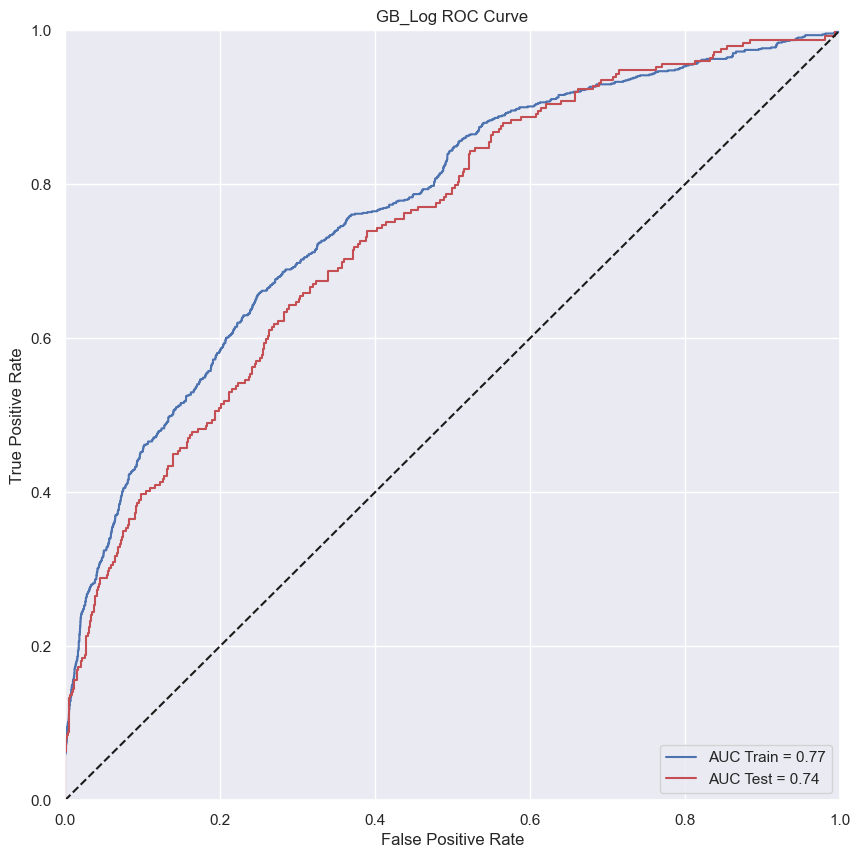

{'INTERCEPT': -2.320957291728195,
 'IMP_DEBTINC': 0.05329433022590466,
 'IMP_DELINQ': 0.7991356914740488,
 'IMP_CLAGE': -0.007836337929966007,
 'IMP_VALUE': -5.1752135723732e-07}

In [85]:
GB_Log = LogModel('GB_Log',X_train[treeflag.important_variables], X_test[treeflag.important_variables], Y_train, Y_test)
GB_Log.fit()
GB_Log.getAccuracy()
GB_Log.makeROCplot('pickle')
GB_Log.getVars()

c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\TK\Anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search alg

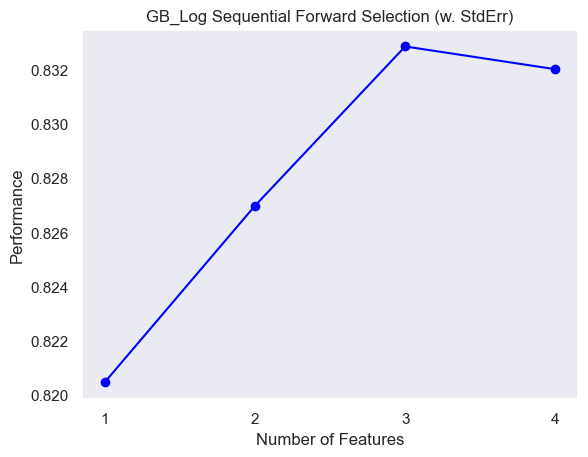

['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_CLAGE']

In [92]:
GB_Log_Step = StepWiseModel('GB_Log',X_train[treeflag.important_variables], X_test[treeflag.important_variables], Y_train, Y_test, 'Logistic',
                solver='newton-cg',maxiter=100,kmax=X_train[treeflag.important_variables].shape[1],forward=True,floating=False,scoring='r2',cv=3)
GB_Log_Step.fit()
GB_Log_Step.plot('pickle1')
GB_Log_Step.getMax()
GB_Log_Step.important_variables
